<a href="https://colab.research.google.com/github/vaibhavyesalwad/Grapes-semantic-segmentation/blob/master/Grapes_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
import keras
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses
import albumentations as A
from tensorflow.keras import callbacks

# Loading dataset from google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/Segmentation-grapes

grapes-dataset.zip  weights


In [4]:
!cp /mydrive/Segmentation-grapes/grapes-dataset.zip ../

In [5]:
!unzip ../grapes-dataset.zip

Archive:  ../grapes-dataset.zip
   creating: grapes-dataset/
   creating: grapes-dataset/train-masks/
  inflating: grapes-dataset/train-masks/CSV_1874.png  
  inflating: grapes-dataset/train-masks/SVB_1971.png  
  inflating: grapes-dataset/train-masks/CSV_1911.png  
  inflating: grapes-dataset/train-masks/CDY_2028.png  
  inflating: grapes-dataset/train-masks/CFR_1647.png  
  inflating: grapes-dataset/train-masks/CDY_20180427_153144437_BURST000_COVER_TOP.png  
  inflating: grapes-dataset/train-masks/SVB_1946.png  
  inflating: grapes-dataset/train-masks/CFR_20180427_141158495.png  
  inflating: grapes-dataset/train-masks/SYH_2017-04-27_1271.png  
  inflating: grapes-dataset/train-masks/SVB_1955.png  
  inflating: grapes-dataset/train-masks/CSV_20180427_144513954.png  
  inflating: grapes-dataset/train-masks/CSV_1901.png  
  inflating: grapes-dataset/train-masks/CSV_1899.png  
  inflating: grapes-dataset/train-masks/CSV_1891.png  
  inflating: grapes-dataset/train-masks/CDY_2019.png  
 

# Data Pre-processing

In [6]:
os.chdir('grapes-dataset')
os.getcwd()

'/content/grapes-dataset'

In [7]:
TRAIN_IMAGES_PATH = 'train-images/'
TRAIN_MASKS_PATH = 'train-masks/'
TEST_IMAGES_PATH = 'test-images/'
TEST_MASKS_PATH = 'test-masks/'

In [ ]:
filenames = os.listdir(TRAIN_IMAGES_PATH)

In [ ]:
print(f'Total train images : {len(filenames)}  and total train masks: {len(os.listdir(TRAIN_MASKS_PATH))}')

Total train images : 110  and total train masks: 110


Knowing image shape of train dataset and making it uniform

In [ ]:
unique_shapes = []
for name in filenames:
  img = cv2.imread(TRAIN_IMAGES_PATH + name)
  if img.shape not in unique_shapes:
    unique_shapes.append(img.shape)
else:
  print(unique_shapes)

[(1365, 2048, 3), (1536, 2048, 3)]


Resizing it train images shape to (704, 1024, 3) & keeping aspect ratio same and it will also help to boost up training

In [ ]:
resultant_shape = (1024, 704)

for name in filenames:
  img = cv2.imread(TRAIN_IMAGES_PATH + name)
  img = cv2.resize(img, resultant_shape)
  cv2.imwrite(TRAIN_IMAGES_PATH + name, img)

  # train images .jpg files but we have .png files for masks
  mask = cv2.imread(TRAIN_MASKS_PATH + name[:-3] + 'png')
  mask = cv2.resize(mask, resultant_shape)
  cv2.imwrite(TRAIN_MASKS_PATH + name[:-3] + 'png', mask)
else:
  print(f'All train-images & train-masks reshaped to {resultant_shape}')

All train-images & train-masks reshaped to (1024, 704)


**Augmenting train images and masks using only mirror
versions**

In [ ]:
mirror_transform = A.Compose([A.HorizontalFlip(always_apply=True)])

In [ ]:
img = cv2.imread(TRAIN_IMAGES_PATH + filenames[0])
mask = cv2.imread(TRAIN_MASKS_PATH + filenames[0][:-3] + 'png')

transformations = mirror_transform(image=img, mask=mask)
mirror_img = transformations['image']
mirror_mask = transformations['mask']

**Let's see mirror transformations**

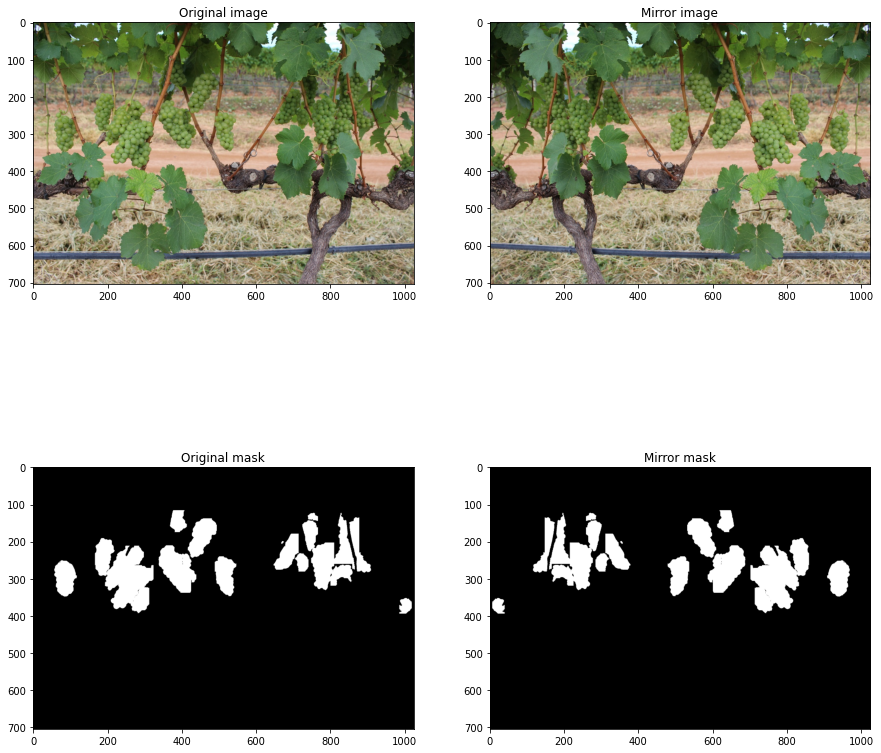

In [ ]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mirror_rgb_img = cv2.cvtColor(mirror_img, cv2.COLOR_BGR2RGB)
mirror_rgb_mask = cv2.cvtColor(mirror_mask, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(2, 2, 1)
ax1.title.set_text('Original image')
ax1.imshow(rgb_img)

ax2 = fig.add_subplot(2, 2, 2)
ax2.title.set_text('Mirror image')
ax2.imshow(mirror_rgb_img)

ax3 = fig.add_subplot(2, 2, 3)
ax3.title.set_text('Original mask')
ax3.imshow(rgb_mask)

ax4 = fig.add_subplot(2, 2, 4)
ax4.title.set_text('Mirror mask')
ax4.imshow(mirror_rgb_mask)

plt.show()

In [ ]:
for name in filenames:
  img = cv2.imread(TRAIN_IMAGES_PATH + name)
  mask = cv2.imread(TRAIN_MASKS_PATH + name[:-3] + 'png')

  transformations = mirror_transform(image=img, mask=mask)
  img = transformations['image']
  mask = transformations['mask']

  cv2.imwrite(TRAIN_IMAGES_PATH + name[:-4] + '_mirror' + '.jpg', img)
  cv2.imwrite(TRAIN_MASKS_PATH + name[:-4] + '_mirror' + '.png', mask)

else:
  print('Augmenting done check images in train images and train masks')

Augmenting done check images in train images and train masks


In [ ]:
filenames = os.listdir(TRAIN_IMAGES_PATH)
print(f'Now total {len(filenames)} train images and {len(os.listdir(TRAIN_IMAGES_PATH))} train masks')

Now total 220 train images and 220 train masks


# Creating labels/numpy files from masks

In [ ]:
!mkdir numpy-files

In [ ]:
i =1
for name in filenames:
  # print(i)
  mask = cv2.imread('train-masks/' + name[:-3] + 'png')
  height, width, _ = mask.shape

  # we can see two colors in masks white [255, 255, 255] and black[0, 0, 0]
  blue = (mask[:, :, 0] == 255)
  green = (mask[:, :, 1] == 255) 
  red = (mask[:, :, 2] == 255)
  
  label = np.logical_and(blue, green, red)
  np.save('numpy-files/' + name[:-3] + 'npy', label)
  
  if i==1:
    print(f'Shape of labels is {label.shape}')

  i +=1  

Shape of labels is (704, 1024)


In [ ]:
width, height = resultant_shape

# Defining different steps in Unet model

In [8]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


# Unet model 

In [9]:
def UNet(height, width):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((height, width, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

# Using binary cross entropy dice loss and dice coeficient as metrics

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)  
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
model = UNet(704, 1024)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=dice_coeff)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 704, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 704, 1024, 16 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 704, 1024, 16 2320        conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 352, 512, 16) 0           conv2d_11[0][0]                  
_______________________________________________________________________________________

**Loading train images & corresponding labels**

In [ ]:
NUMPY_FILES_PATH = 'numpy-files/'

In [ ]:
img_train = np.array([np.array(cv2.imread(TRAIN_IMAGES_PATH + name)) for name in filenames])
label_train = np.array([np.array(np.load(NUMPY_FILES_PATH + name[:-3] + 'npy')) for name in filenames])

In [ ]:
img_train.shape, label_train.shape

((220, 704, 1024, 3), (220, 704, 1024))

In [ ]:
label_train =np.expand_dims(label_train, axis=3)
label_train.shape

(220, 704, 1024, 1)

**Start training the model**

In [ ]:
call_back = [callbacks.ModelCheckpoint(filepath='/mydrive/Segmentation-grapes/weights/grapes_unet.hdf5', 
                              save_best_only=True, monitor='val_dice_coeff', mode='max', verbose=1),
             callbacks.EarlyStopping(monitor='val_dice_coeff', patience=10, verbose=1, min_delta=1e-4, mode='max')]


In [ ]:
model.fit(x=img_train, y=label_train, epochs=100,validation_split=0.2, batch_size=8,
          verbose=1, callbacks=call_back)  

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.6059 - dice_coeff: 0.1864WARNING:tensorflow:Model was constructed with shape (None, 2048, 1376, 3) for input Tensor("input_1:0", shape=(None, 2048, 1376, 3), dtype=float32), but it was called on an input with incompatible shape (None, 704, 1024, 3).

Epoch 00001: val_dice_coeff improved from -inf to 0.18425, saving model to /mydrive/Segmentation-grapes/weights/grapes_unet.hdf5
22/22 [==============================] - 11s 479ms/step - loss: 1.6059 - dice_coeff: 0.1864 - val_loss: 1.1809 - val_dice_coeff: 0.1842
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.1244 - dice_coeff: 0.2323
Epoch 00002: val_dice_coeff improved from 0.18425 to 0.22021, saving model to /mydrive/Segmentation-grapes/weights/grapes_unet.hdf5
22/22 [==============================] - 10s 462ms/step - loss: 1.1244 - dice_coeff: 0.2323 - val_loss: 1.1336 - val_dice_coeff: 0.2202
Epoch 3/100
22/22 [=============================

## Predicting on test dataset

Using saved model

In [11]:
height, width = 704, 1024
model = UNet(height, width)

Loading weights from trained model

In [13]:
model.load_weights('/mydrive/Segmentation-grapes/weights/grapes_unet.hdf5')

In [14]:
def predict(img):
  img = cv2.resize(img, (width, height))
  # print(img.shape)
  img = np.expand_dims(img, axis=0)
  # print(img.shape)
  result = model.predict(img)
  result_mask = np.where(result[0] >= 0.5, 1, 0)
  
  color_of_grapes = [255, 255, 255]
  gray_img = np.zeros((height, width, 3))
  for i in range(3):
    gray_img[:, :, i] = np.where(result_mask > 0, color_of_grapes[i], 0).reshape(height, width)
  
  return gray_img

In [15]:
test_filenames = os.listdir(TEST_IMAGES_PATH)
img = cv2.imread(TEST_IMAGES_PATH + test_filenames[0])
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(TEST_MASKS_PATH + test_filenames[0][:-3] + 'png')
rgb_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

In [16]:
prediction = predict(img)
prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]))
rgb_prediction = cv2.cvtColor(prediction.astype('uint8'), cv2.COLOR_BGR2RGB)

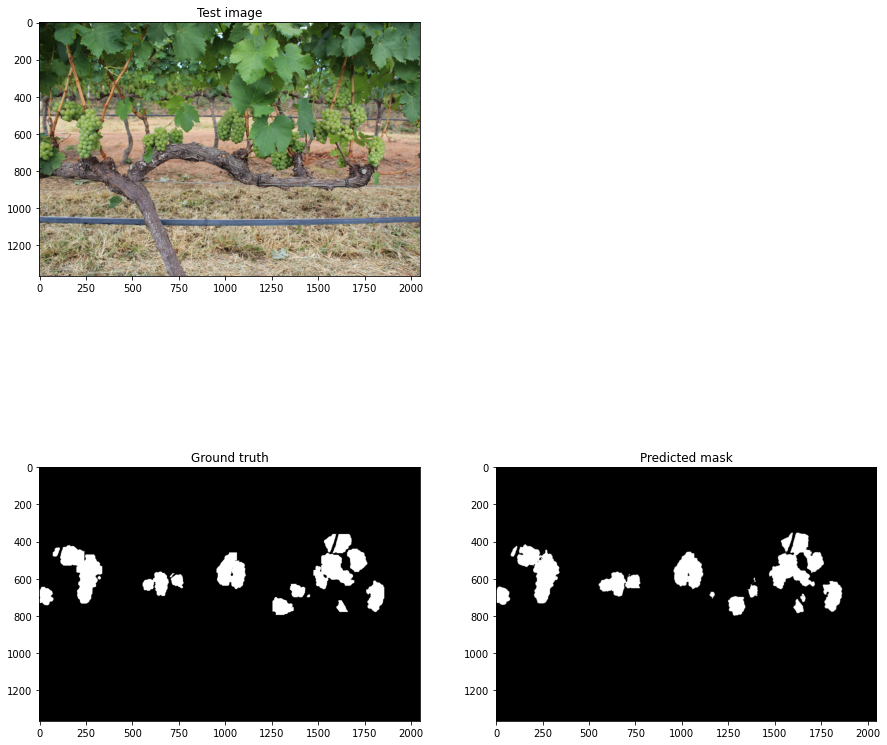

In [18]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(2, 2, 1)
ax1.title.set_text('Test image')
ax1.imshow(rgb_img)

ax3 = fig.add_subplot(2, 2, 3)
ax3.title.set_text('Ground truth')
ax3.imshow(rgb_mask)

ax4 = fig.add_subplot(2, 2, 4)
ax4.title.set_text('Predicted mask')
ax4.imshow(rgb_prediction)
plt.show()